Import Libraries

In [ ]:

import pandas as pd
import requests
import io
import os
import matplotlib.pyplot as plt
import folium
from geopy.distance import geodesic


Define Function to Fetch Dataset

In [ ]:
#Define function to fetch dataset from City of Melbourne API
def fetch_dataset_csv(base_url, dataset, api_key):
    suffix = 'exports/csv?delimiter=%3B&list_separator=%2C&quote_all=false&with_bom=true'
    url = f"{base_url}{dataset}/{suffix}"
    params = {'api_key': api_key}

    response = requests.get(url, params=params, timeout=20)
    response.raise_for_status()
    return pd.read_csv(io.BytesIO(response.content), delimiter=';')


API Key & Base URL

In [ ]:
# API Key & Base URL
API_KEY = os.environ.get('MELBOURNE_API_KEY', input("Enter your Melbourne Open Data API Key: "))
BASE_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'


Enter your Melbourne Open Data API Key: c97d0862931f037ff91e87f9d4700b01ece1b145274b3ca4fa01629e


Dataset IDs

In [ ]:
#  Dataset IDs
BUSINESS_DATASET = 'business-establishments-with-address-and-industry-classification'
PEDESTRIAN_DATASET = 'pedestrian-counting-system-monthly-counts-per-hour'


Fetch & Clean Business Dataset

In [ ]:
#  Fetch and clean business dataset
business_df = fetch_dataset_csv(BASE_URL, BUSINESS_DATASET, API_KEY)

# 1. Convert coordinates to numeric
business_df['latitude'] = pd.to_numeric(business_df['latitude'], errors='coerce')
business_df['longitude'] = pd.to_numeric(business_df['longitude'], errors='coerce')

# 2. Drop rows without coordinates
business_df = business_df.dropna(subset=['latitude','longitude'])

# 3. Drop duplicates if business name + address exist
if 'business_name' in business_df.columns and 'address' in business_df.columns:
    business_df = business_df.drop_duplicates(subset=['business_name','address'])

# 4. Keep only columns relevant to analysis
keep_cols = ['business_name','industry_classification','latitude','longitude']
business_df = business_df[[c for c in keep_cols if c in business_df.columns]]

print("Cleaned business dataset shape:", business_df.shape)
business_df.head()


Cleaned business dataset shape: (389093, 2)


,latitude,longitude
0,-37.817313,144.961435
1,-37.817379,144.961211
2,-37.817379,144.961211
3,-37.817504,144.961010
4,-37.818046,144.960819


Fetch Pedestrian Dataset

In [ ]:
#  Fetch pedestrian dataset
pedestrian_df = fetch_dataset_csv(BASE_URL, PEDESTRIAN_DATASET, API_KEY)

print("Pedestrian dataset shape:", pedestrian_df.shape)
pedestrian_df.head()


Pedestrian dataset shape: (1364552, 9)


,id,location_id,sensing_date,hourday,direction_1,direction_2,pedestriancount,sensor_name,location
0,5320230926,5,2023-09-26,3,14,7,21,PriNW_T,"-37.81874249, 144.96787656"
1,39720231122,39,2023-11-22,7,124,62,186,AlfPl_T,"-37.81379749, 144.96995745"
2,1651720241216,165,2024-12-16,17,60,37,97,Spen475_T,"-37.80953359, 144.94939004"
3,302020240124,30,2024-01-24,20,201,304,505,Lon189_T,"-37.8112185, 144.96656806"
4,621320250304,62,2025-03-04,13,363,271,634,Lat224_T,"-37.80996494, 144.96216521"


Fetch and Merge Sensor Locations

In [ ]:
# Fetch the Pedestrian Sensor Locations dataset (for coordinates)
LOCATIONS_DATASET = 'pedestrian-counting-system-sensor-locations'
locations_df = fetch_dataset_csv(BASE_URL, LOCATIONS_DATASET, API_KEY)

# Preview available columns
print("Sensor locations columns:", locations_df.columns.tolist())

# Merge pedestrian data with coordinates using 'sensor_name'
pedestrian_df = pedestrian_df.merge(
    locations_df[['sensor_name','latitude','longitude']],
    on='sensor_name',
    how='left'
)

# Verify coordinates now exist
pedestrian_df[['sensor_name','latitude','longitude']].head()


Sensor locations columns: ['location_id', 'sensor_description', 'sensor_name', 'installation_date', 'note', 'location_type', 'status', 'direction_1', 'direction_2', 'latitude', 'longitude', 'location']


,sensor_name,latitude,longitude
0,PriNW_T,-37.818742,144.967877
1,AlfPl_T,-37.813797,144.969957
2,Spen475_T,-37.809534,144.949390
3,Lon189_T,-37.811219,144.966568
4,Lat224_T,-37.809965,144.962165


Clean Pedestrian Dataset

In [ ]:
#  Clean pedestrian dataset
pedestrian_df = pedestrian_df.rename(columns={
    'sensing_date': 'date',
    'hourday': 'hour',
    'pedestriancount': 'hourly_count'
})

# Convert date to datetime
pedestrian_df['date'] = pd.to_datetime(pedestrian_df['date'], errors='coerce')

# Create full datetime
pedestrian_df['date_time'] = pd.to_datetime(
    pedestrian_df['date'].astype(str) + ' ' + pedestrian_df['hour'].astype(str) + ':00',
    errors='coerce'
)

# Convert coordinates
pedestrian_df['latitude'] = pd.to_numeric(pedestrian_df['latitude'], errors='coerce')
pedestrian_df['longitude'] = pd.to_numeric(pedestrian_df['longitude'], errors='coerce')

# Drop rows without coordinates
pedestrian_df = pedestrian_df.dropna(subset=['latitude','longitude'])

pedestrian_df[['sensor_name','date_time','hourly_count']].head()


,sensor_name,date_time,hourly_count
0,PriNW_T,2023-09-26 03:00:00,21
1,AlfPl_T,2023-11-22 07:00:00,186
2,Spen475_T,2024-12-16 17:00:00,97
3,Lon189_T,2024-01-24 20:00:00,505
4,Lat224_T,2025-03-04 13:00:00,634


Filter Weekends

In [ ]:
#  Filter weekends (Saturday & Sunday)
pedestrian_df['weekday'] = pedestrian_df['date_time'].dt.day_name()
weekend_df = pedestrian_df[pedestrian_df['weekday'].isin(['Saturday','Sunday'])]
weekend_df = weekend_df[['sensor_name','date_time','hourly_count','latitude','longitude','weekday']]
weekend_df.head()


,sensor_name,date_time,hourly_count,latitude,longitude,weekday
12,WebBN_T,2024-12-01 17:00:00,395,-37.822935,144.947175,Sunday
16,Eli250_T,2024-06-02 12:00:00,1553,-37.812585,144.962578,Sunday
20,ACMI_T,2024-08-24 20:00:00,709,-37.817263,144.968728,Saturday
21,BirFed1120_T,2025-01-12 15:00:00,113,-37.818414,144.973579,Sunday
27,LtB210_T,2025-06-28 02:00:00,177,-37.812372,144.965507,Saturday


Aggregate Weekend Foot Traffic

In [ ]:
#  Aggregate weekend traffic per sensor
weekend_summary = (
    weekend_df.groupby(['sensor_name','latitude','longitude'])['hourly_count']
    .sum()
    .reset_index()
    .rename(columns={'hourly_count':'total_weekend_count'})
    .sort_values(by='total_weekend_count', ascending=False)
)
weekend_summary.head()


,sensor_name,latitude,longitude,total_weekend_count
75,SouthB_T,-37.820187,144.965085,7774019
87,Swa31,-37.816686,144.966897,6730773
69,QVN_T,-37.810578,144.964443,6209056
27,ElFi_T,-37.817980,144.965034,5835126
28,Eli250_T,-37.812585,144.962578,4629168


Top 10 Weekend Locations

In [ ]:
#  Extract top 10 busiest weekend sensors
top10_weekend = weekend_summary.head(10)
top10_weekend


,sensor_name,latitude,longitude,total_weekend_count
75,SouthB_T,-37.820187,144.965085,7774019
87,Swa31,-37.816686,144.966897,6730773
69,QVN_T,-37.810578,144.964443,6209056
27,ElFi_T,-37.817980,144.965034,5835126
28,Eli250_T,-37.812585,144.962578,4629168
84,Swa123_T,-37.814880,144.966088,4553042
86,Swa295_T,-37.811015,144.964295,4057461
62,MCEC_T,-37.824018,144.956044,3989703
85,Swa148_T,-37.814141,144.966094,3926539
93,VAC_T,-37.821299,144.968793,3851844


Bar Chart

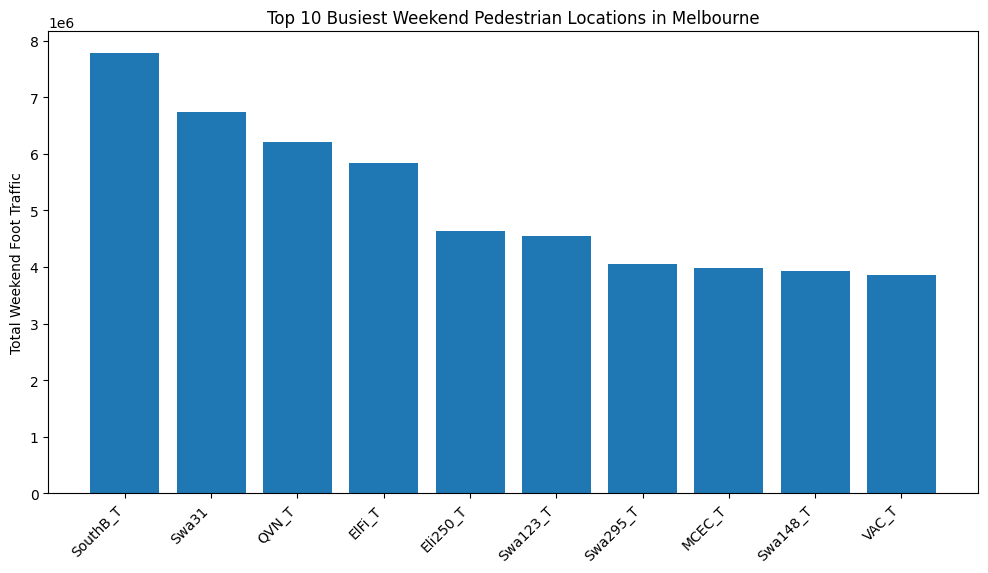

In [ ]:
#  Bar chart of top 10 weekend locations
plt.figure(figsize=(12,6))
plt.bar(top10_weekend['sensor_name'], top10_weekend['total_weekend_count'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Total Weekend Foot Traffic")
plt.title("Top 10 Busiest Weekend Pedestrian Locations in Melbourne")
plt.show()


Folium Map - Top 10 Sensors

In [ ]:
#  Folium map of top 10 weekend sensors
melbourne_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=13)

for _, row in top10_weekend.iterrows():
    popup_text = f"{row['sensor_name']}<br>Total Weekend Count: {row['total_weekend_count']}"
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=popup_text,
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(melbourne_map)

melbourne_map


Merge with Business Data (Distance-Based)

In [ ]:
import numpy as np

#  Optimized calculation of nearby businesses

def haversine_np(lat1, lon1, lat2, lon2):
    """
    Vectorized Haversine distance in meters.
    lat1/lon1 can be scalar (sensor),
    lat2/lon2 are NumPy arrays (business locations).
    """
    R = 6371000  # Earth radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    return 2*R*np.arcsin(np.sqrt(a))

nearby_counts = []

for _, sensor in top10_weekend.iterrows():
    # 1. Quick bounding box filter (~200m ~ 0.002 degrees)
    subset = business_df[
        (business_df['latitude']  >= sensor['latitude']-0.002) &
        (business_df['latitude']  <= sensor['latitude']+0.002) &
        (business_df['longitude'] >= sensor['longitude']-0.002) &
        (business_df['longitude'] <= sensor['longitude']+0.002)
    ]

    # 2. Compute vectorized haversine distance
    distances = haversine_np(sensor['latitude'], sensor['longitude'],
                             subset['latitude'].values, subset['longitude'].values)

    # 3. Count businesses within 200 meters
    nearby_counts.append((distances <= 200).sum())

# Add results to top 10 dataframe
top10_weekend = weekend_summary.head(10).copy()

top10_weekend['nearby_businesses'] = nearby_counts
display(top10_weekend)


,sensor_name,latitude,longitude,total_weekend_count,nearby_businesses
75,SouthB_T,-37.820187,144.965085,7774019,4292
87,Swa31,-37.816686,144.966897,6730773,20034
69,QVN_T,-37.810578,144.964443,6209056,12805
27,ElFi_T,-37.817980,144.965034,5835126,12989
28,Eli250_T,-37.812585,144.962578,4629168,17257
84,Swa123_T,-37.814880,144.966088,4553042,23571
86,Swa295_T,-37.811015,144.964295,4057461,15982
62,MCEC_T,-37.824018,144.956044,3989703,170
85,Swa148_T,-37.814141,144.966094,3926539,18753
93,VAC_T,-37.821299,144.968793,3851844,516


Folium Map with Business Impact

In [ ]:
#  Map with weekend traffic and nearby business counts (Optimized)

melbourne_map2 = folium.Map(location=[-37.8136, 144.9631], zoom_start=13)

for _, row in top10_weekend.iterrows():
    popup_text = (f"{row['sensor_name']}<br>"
                  f"Weekend Foot Traffic: {row['total_weekend_count']}<br>"
                  f"Nearby Businesses: {row['nearby_businesses']}")
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=popup_text,
        icon=folium.Icon(color='green', icon='briefcase')
    ).add_to(melbourne_map2)

melbourne_map2


Insights

In [ ]:
#  Print Weekend Business Activity Insights

print("\n--- Weekend Business Activity Insights ---\n")

# 1. Identify the busiest weekend sensor
busiest_sensor = top10_weekend.iloc[0]['sensor_name']
busiest_count = top10_weekend.iloc[0]['total_weekend_count']

print(f"- The busiest weekend pedestrian location is {busiest_sensor}, "
      f"with {busiest_count} total weekend foot traffic.\n")

# 2. Show top 3 weekend locations with nearby business counts
print("- Top 3 weekend pedestrian locations and nearby businesses:")
for i in range(min(3, len(top10_weekend))):
    row = top10_weekend.iloc[i]
    print(f"  {i+1}. {row['sensor_name']} – {row['total_weekend_count']} people "
          f"with {row['nearby_businesses']} nearby businesses")

# 3. Business recommendation
print("\n- Recommendation:")
print("  Businesses near these high-foot-traffic areas could benefit from:")
print("    • Extended weekend opening hours")
print("    • Special promotions or discounts")
print("    • Hosting local weekend events to attract more customers")



--- Weekend Business Activity Insights ---

- The busiest weekend pedestrian location is SouthB_T, with 7774019 total weekend foot traffic.

- Top 3 weekend pedestrian locations and nearby businesses:
  1. SouthB_T – 7774019 people with 4292 nearby businesses
  2. Swa31 – 6730773 people with 20034 nearby businesses
  3. QVN_T – 6209056 people with 12805 nearby businesses

- Recommendation:
  Businesses near these high-foot-traffic areas could benefit from:
    • Extended weekend opening hours
    • Special promotions or discounts
    • Hosting local weekend events to attract more customers
